# Preamble

In [74]:
# Imports
## General
import numpy as np
import pickle as pkl
import json
import warnings
warnings.filterwarnings('ignore')
import gc

## Data manipulation and preprocessing
import pandas as pd
import boto3
from sklearn.preprocessing import StandardScaler, FunctionTransformer,LabelEncoder, MinMaxScaler,OrdinalEncoder
#import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, MissingIndicator
from sklearn.ensemble import HistGradientBoostingRegressor
from scipy import sparse

## Pre-processing functions
def criteo_log_transform(z):
    if z>2:
        return np.log(z)**2
    else:
        return z
def map_criteo_log_transform(x):
    return x.map(criteo_log_transform)

def decode_byte(x):
    try:
        return x.decode()
    except AttributeError:
        return '-1'

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image

## Modelling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
from fastFM import sgd
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.models import Sequential
import tensorflow as tf
from deepctr.models.fnn import FNN
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names
from deepctr.models.pnn import PNN
from deepctr.models.wdl import WDL

# Introduction

As outlined in the Feasibility secition of my Milestone 3 submission, I have segmented the work over the next few weeks according to the following timeline

![](figures/timeline.png)

Below I proceed by structuring my response according to the following sections
- Model Specific Research
- Data exploration, preprocessing and environment setup
- Model Replication and Experimentation

# Model Specific Research

*__Fill out details from readings__*

On the basis of my reasearch and published results, I have chosen to investigate the following models:

__Shallow__
- Logistic Regression
- Factorization Machines

__Deep__
- Factorization Supported Neural Networks
- Product Based Neural Networks
- Wide and Deep
- DeepFM
- Feature Generation by Convolutional Neural Networks
- Automatic Feature Interaction (AutoInt)

# Data Exploration, Caching, Preprocessing pipeline

## Cache the datasets from S3

In [2]:
# Retrieve the kdd12 train file
kdd12_train_path = tf.keras.utils.get_file(
    fname="kdd12_training.csv", 
    origin="https://mlds-final-project-bucket.s3.eu-west-2.amazonaws.com/kdd12/train/training/training.txt",
    cache_dir="./data",
    cache_subdir="kdd12"
)

10598457344/10598454239 [==============================] - 106s 0us/step


In [28]:
# Retrieve the kdd12 test file
kdd12_test_path = tf.keras.utils.get_file(
    fname="kdd12_test.csv", 
    origin="https://mlds-final-project-bucket.s3.eu-west-2.amazonaws.com/kdd12/test/test.txt",
    cache_dir="./data",
    cache_subdir="kdd12"
)
print(kdd12_test_path)

1354121216/1354115448 [==============================] - 14s 0us/step
./data/kdd12/kdd12_test.csv


In [30]:
# Retrieve the Avazu train file
avazu_train_path = tf.keras.utils.get_file(
    fname="avazu_train.csv", 
    origin="https://mlds-final-project-bucket.s3.eu-west-2.amazonaws.com/avazu/train/train.csv",
    cache_dir="./data",
    cache_subdir="avazu"
)
print(avazu_train_path)

6311149568/6311147778 [==============================] - 63s 0us/step
./data/avazu/avazu_train.csv


In [31]:
# Retrieve the Avazu test file
avazu_test_path = tf.keras.utils.get_file(
    fname="avazu_test.csv", 
    origin="https://mlds-final-project-bucket.s3.eu-west-2.amazonaws.com/avazu/test/test.csv",
    cache_dir="./data",
    cache_subdir="avazu"
)
print(avazu_test_path)

705798144/705791442 [==============================] - 7s 0us/step
./data/avazu/avazu_test.csv


In [34]:
# Retrieve the Criteo train file
criteo_train_path = tf.keras.utils.get_file(
    fname="criteo_train.csv",
    origin="https://mlds-final-project-bucket.s3.eu-west-2.amazonaws.com/dac/train/train.txt",
    cache_dir="./data",
    cache_subdir="criteo"
)
print(criteo_train_path)

11147190272/11147184845 [==============================] - 113s 0us/step
./data/criteo/criteo_train.csv


In [35]:
# Retrieve the Criteo test file
criteo_test_path = tf.keras.utils.get_file(
    fname="criteo_test.csv",
    origin="https://mlds-final-project-bucket.s3.eu-west-2.amazonaws.com/dac/test/test.txt",
    cache_dir="./data",
    cache_subdir="criteo"
)
print(criteo_test_path)

1460248576/1460246311 [==============================] - 15s 0us/step
./data/criteo/criteo_test.csv


## Load them as tf.datasets

In [2]:
# Load the kdd12_train dataset
kdd12_train = tf.data.experimental.make_csv_dataset(
    './data/kdd12/kdd12_training.csv',
    batch_size=1,
    field_delim='\t',
    header=False,
    column_names=['Click','Impression','DisplayURL','AdID','AdvertiserID','Depth','Position','QueryID','KeywordID','TitleID','DescriptionID','UserID'],
    column_defaults=['int32','int32','string','string','string','int32','int32','string','string','string','string','string'],
    num_epochs=1,
    shuffle=True,
    shuffle_buffer_size=100,
    shuffle_seed=42,
    #ignore_errors=True
)

2024-07-29 16:01:02.449032: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-07-29 16:01:02.452643: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-29 16:01:02.463085: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [3]:
# Define function for separating input and target for kdd12
def sep_features_labels(elem):
    label = elem.pop(key='Click')
    return elem, label

In [4]:
# Map along kdd12 dataset to separate the label and featurs
kdd12_train = kdd12_train.map(sep_features_labels)

In [5]:
# Check that the element spec is correct
print(kdd12_train.element_spec)

(OrderedDict([('Impression', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('DisplayURL', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('AdID', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('AdvertiserID', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('Depth', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('Position', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('QueryID', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('KeywordID', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('TitleID', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('DescriptionID', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('UserID', TensorSpec(shape=(None,), dtype=tf.string, name=None))]), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [12]:
column_defaults=[
    'string',
    'int',
    'int32',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string'
]

# Load the Avazu train dataset
avazu_train = tf.data.experimental.make_csv_dataset(
    './data/avazu/avazu_train.csv',
    batch_size=1,
    field_delim=',',
    header=True,
    column_defaults=column_defaults,
    label_name='click',
    num_epochs=1,
    shuffle=True,
    shuffle_buffer_size=100,
    shuffle_seed=42,
    #ignore_errors=True
)

In [19]:
# Check the avazu_train element spec
print(avazu_train.element_spec)

(OrderedDict([('id', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('hour', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('C1', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('banner_pos', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('site_id', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('site_domain', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('site_category', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('app_id', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('app_domain', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('app_category', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('device_id', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('device_ip', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('device_model', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('device_type', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('device_conn_t

In [20]:
# Load the Criteo train dataset

criteo_names = ['Click']
for i in range(1, 14):
    criteo_names.append('int_{0}'.format(i))

for i in range(1, 27):
    criteo_names.append('cat_{0}'.format(i))

column_defaults = ['int'] + 13*['int32'] + 26*['string']

criteo_train = tf.data.experimental.make_csv_dataset(
    './data/criteo/criteo_train.csv',
    batch_size=1,
    field_delim='\t',
    header=False,
    column_names=criteo_names,
    column_defaults=column_defaults,
    num_epochs=1,
    shuffle=True,
    shuffle_buffer_size=100,
    shuffle_seed=42,
    #ignore_errors=True
)

In [21]:
# Separate features and labels
criteo_train = criteo_train.map(sep_features_labels)

In [22]:
# Print element spec
print(criteo_train.element_spec)

(OrderedDict([('int_1', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('int_2', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('int_3', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('int_4', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('int_5', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('int_6', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('int_7', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('int_8', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('int_9', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('int_10', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('int_11', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('int_12', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('int_13', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('cat_1', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('cat_2', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('cat

## Exploratory Data Analysis

I first perform an exploratory data analysis to show the type of preprocessing that needs to be made. In order to simplify the data processing requirements, I do this on the basis of $n=10000$ row samples of the data.

### Create data samples

In [44]:
n = 10000

# Get the samples as pandas dataframes

## kdd12
kdd12_train_sample = pd.DataFrame(columns=list(kdd12_train.element_spec[0].keys())+['click'])
for elem in kdd12_train.take(n):
    features, label=elem
    df = pd.DataFrame(features)
    df['click'] = label.numpy()
    kdd12_train_sample = pd.concat([kdd12_train_sample,df],ignore_index=True)

## avazu
avazu_train_sample = pd.DataFrame(columns=list(avazu_train.element_spec[0].keys()) + ['click'])
for elem in avazu_train.take(n):
    features, label=elem
    df = pd.DataFrame(features)
    df['click'] = label.numpy()
    avazu_train_sample = pd.concat([avazu_train_sample,df],ignore_index=True)

## criteo
criteo_train_sample = pd.DataFrame(columns=list(criteo_train.element_spec[0].keys()) + ['click'])
for elem in criteo_train.take(n):
    features, label=elem
    df = pd.DataFrame(features)
    df['click'] = label.numpy()
    criteo_train_sample = pd.concat([criteo_train_sample,df],ignore_index=True)

In [45]:
# Show all of the datasets
kdd12_train_sample.head()

,Impression,DisplayURL,AdID,AdvertiserID,Depth,Position,QueryID,KeywordID,TitleID,DescriptionID,UserID,click
0,1,7.797032e+18,20563185,5476,3,1,16382,8074,13039,9917,86056,0
1,3,1.276194e+19,21220411,2636,1,1,84,124,537,712,444906,0
2,1,1.066459e+19,20801912,30128,2,1,13171922,1493,3224,5611,490234,0
3,1,1.552089e+19,2547220,25051,1,1,499592,429536,325336,63672,86056,0
4,1,7.903915e+18,21162422,1325,3,2,16382,24830,48371,51775,86056,0


In [46]:
avazu_train_sample.head()

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,click
0,1.000791e+19,14102100,1005,1,b'0eb72673',b'd2f72222',b'f028772b',b'ecad2386',b'7801e8d9',b'07d7df22',...,0,16208,320,50,1800,3,167,100075,23,0
1,1.001489e+19,14102100,1005,0,b'85f751fd',b'c4e18dd6',b'50e219e0',b'e2fcccd2',b'5c5a694b',b'0f2161f8',...,0,4687,320,50,423,2,39,100148,32,1
2,1.000418e+19,14102100,1005,1,b'0c2fe9d6',b'27e3c518',b'28905ebd',b'ecad2386',b'7801e8d9',b'07d7df22',...,0,6558,320,50,571,2,39,-1,32,0
3,1.000981e+19,14102100,1005,0,b'85f751fd',b'c4e18dd6',b'50e219e0',b'396df801',b'2347f47a',b'0f2161f8',...,0,15705,320,50,1722,0,35,100084,79,0
4,1.000696e+19,14102100,1005,0,b'85f751fd',b'c4e18dd6',b'50e219e0',b'0acbeaa3',b'45a51db4',b'f95efa07',...,0,18993,320,50,2161,0,35,100034,157,1


In [47]:
criteo_train_sample.head()

,int_1,int_2,int_3,int_4,int_5,int_6,int_7,int_8,int_9,int_10,...,cat_18,cat_19,cat_20,cat_21,cat_22,cat_23,cat_24,cat_25,cat_26,click
0,0,0,55,5,14477,0,0,5,1,0,...,b'5aed7436',b'55dd3565',b'5840adea',b'c412f773',b'',b'3a171ecb',b'3fdb382b',b'e8b83407',b'ccc71a58',1
1,0,-1,0,0,5760,42,218,0,287,0,...,b'88416823',b'',b'',b'',b'ad3062eb',b'423fab69',b'',b'',b'',1
2,2,0,1,14,767,89,4,2,245,1,...,b'3412118d',b'',b'',b'e587c466',b'ad3062eb',b'3a171ecb',b'3b183c5c',b'',b'',0
3,0,127,1,3,1683,19,26,17,475,0,...,b'bd17c3da',b'f6a3e43b',b'a458ea53',b'35cd95c9',b'ad3062eb',b'c7dc6720',b'3fdb382b',b'010f6491',b'49d68486',1
4,0,78,2,15,4311,85,4,18,230,0,...,b'df00d249',b'',b'',b'f520f961',b'',b'32c7478e',b'27b60b01',b'',b'',1


### Sparse Multi-Value Categorical Features

A common remidy to the above issue is to _bin_ the categorical feature values before one-hot encoding or embedding, according to some given threshold (Cite Song, Others). This essentially means that for a given threshold $t$, we retain only the values for the multi-value categorical features that have more than $t$ occurances in the dataset. (Cite Song) Reccomends usign, setting $t = {10,5,10}$ for Criteo, KDD12 and Avazu respectively.

In [48]:
## Create lists of categorical colums for each dataset
kdd12_categorical_columns = [
    'DisplayURL',
    'AdID',
    'AdvertiserID',
    'QueryID',
    'KeywordID',
    'TitleID',
    'DescriptionID',
    'UserID'
]

avazu_categorical_columns = [
    'C1',
    'banner_pos',
    'site_id',
    'site_domain',
    'site_category',
    'app_id',
    'app_domain',
    'app_category',
    'device_id',
    'device_ip',
    'device_model',
    'device_type',
    'device_conn_type',
    'C14',
    'C15',
    'C16',
    'C17',
    'C18',
    'C19',
    'C20',
    'C21'
]

criteo_numerical_columns = [f'int_{i}' for i in np.arange(1,14)]
criteo_categorical_columns = [col for col in list(criteo_train.element_spec[0].keys()) if col not in criteo_numerical_columns+['click']]

In [49]:
# Implement one-hot encoding for the categorical features in the three datasets
kdd12_ord_enc = OrdinalEncoder(min_frequency=5,handle_unknown='use_encoded_value',unknown_value=-1)
avazu_ord_enc = OrdinalEncoder(min_frequency=10,handle_unknown='use_encoded_value',unknown_value=-1)
criteo_ord_enc = OrdinalEncoder(min_frequency=10,handle_unknown='use_encoded_value',unknown_value=-1)

In [50]:
# Encode the three datasets
kdd12_train_sample[kdd12_categorical_columns] = kdd12_ord_enc.fit_transform(kdd12_train_sample[kdd12_categorical_columns])
avazu_train_sample[avazu_categorical_columns] = avazu_ord_enc.fit_transform(avazu_train_sample[avazu_categorical_columns])
criteo_train_sample[criteo_categorical_columns] = criteo_ord_enc.fit_transform(criteo_train_sample[criteo_categorical_columns])

### High Variance Numerical Outliers

Below I check the distributions of the numerical features in the datasets. We see that the variance for some of the numerical features in the Criteo dataset are relatively high.

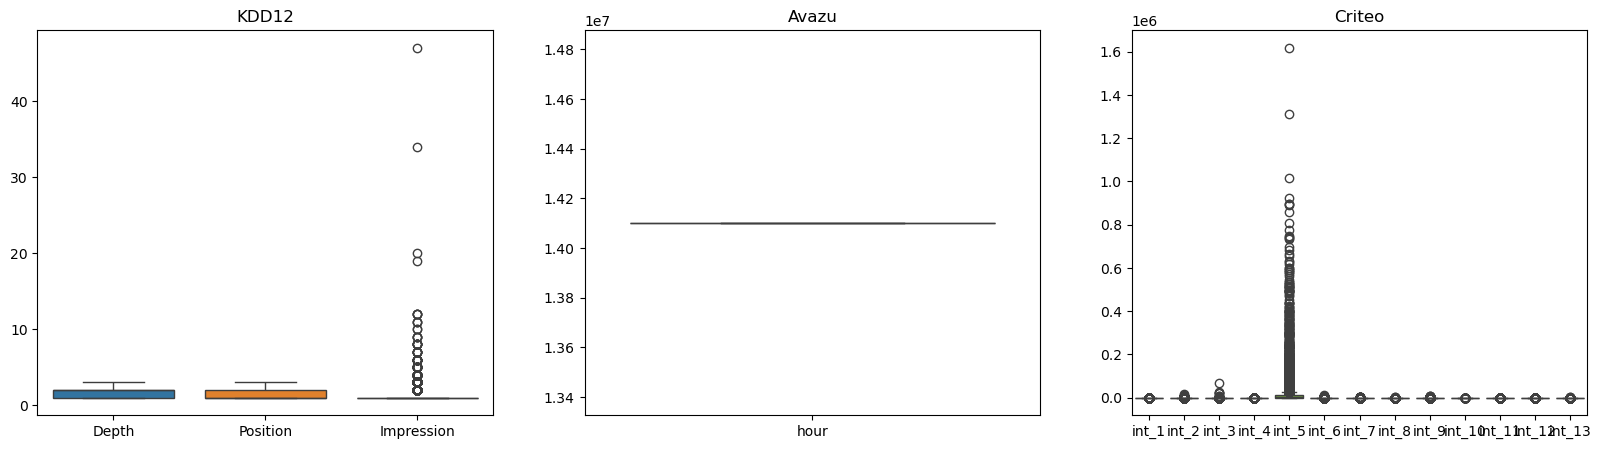

In [51]:
# Plot boxplots for the numerical features in the three datasets
kdd12_numerical_columns = [
    'Depth',
    'Position',
    'Impression'
]

avazu_numerical_columns = [
    'hour'
]

criteo_numerical_columns = [f'int_{i}' for i in np.arange(1,14)]

fig, axs = plt.subplots(1,3, figsize=(20,5))
sns.boxplot(data=kdd12_train_sample[kdd12_numerical_columns], ax=axs[0])
axs[0].set_title('KDD12')
sns.boxplot(data=avazu_train_sample[avazu_numerical_columns], ax=axs[1])
axs[1].set_title('Avazu')
sns.boxplot(data=criteo_train_sample[criteo_numerical_columns], ax=axs[2])
axs[2].set_title('Criteo')
plt.show()

Due to the high variance of numerical features in the Criteo dataset, it is necessary to transform these variable in order to ease the training of deep NN's. As done be ([Song et al (2019)](#Song) and [Wang et al (2023)](#Wang)), we will proceed by applying the transform $\log^2 (z)$ if $z>2$, and where $z$ is the standardized numerical value.

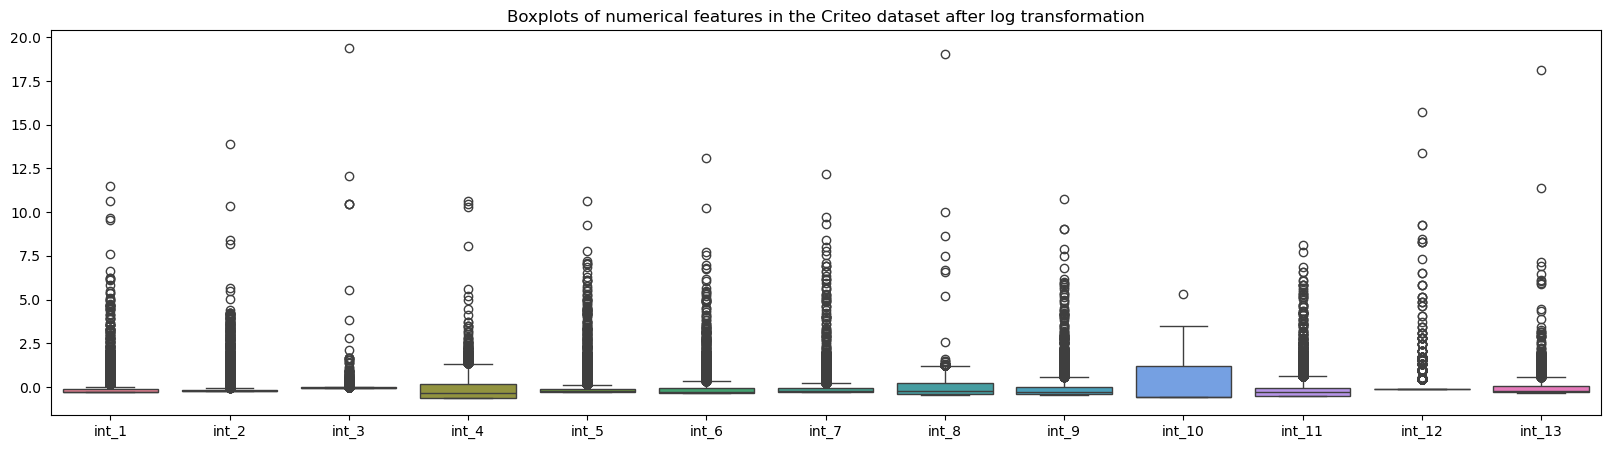

In [52]:
# Standardize the numerical features in the three datasets
kdd12_scaler = StandardScaler()
kdd12_train_sample[kdd12_numerical_columns] = kdd12_scaler.fit_transform(kdd12_train_sample[kdd12_numerical_columns])

avazu_scaler = StandardScaler()
avazu_train_sample[avazu_numerical_columns] = avazu_scaler.fit_transform(avazu_train_sample[avazu_numerical_columns])

criteo_scaler = StandardScaler()
criteo_train_sample[criteo_numerical_columns] = criteo_scaler.fit_transform(criteo_train_sample[criteo_numerical_columns])

criteo_log_transformer = FunctionTransformer(func=map_criteo_log_transform) # The function here is defined in the preamble script
criteo_train_sample[criteo_numerical_columns] = criteo_log_transformer.transform(criteo_train_sample[criteo_numerical_columns])

# Check the result
fig, axs = plt.subplots(1,1, figsize=(20,5))
sns.boxplot(data=criteo_train_sample[[col for col in criteo_numerical_columns]])
plt.title("Boxplots of numerical features in the Criteo dataset after log transformation")
plt.show()

In [53]:
# Export all of the transformers
with open('./preprocessing_pipeline/kdd12_ord_enc.pkl','wb') as f:
    pkl.dump(kdd12_ord_enc, f, protocol=pkl.HIGHEST_PROTOCOL)
with open('./preprocessing_pipeline/avazu_ord_enc.pkl','wb') as f:
    pkl.dump(avazu_ord_enc, f, protocol=pkl.HIGHEST_PROTOCOL)
with open('./preprocessing_pipeline/criteo_ord_enc.pkl','wb') as f:
    pkl.dump(criteo_ord_enc, f, protocol=pkl.HIGHEST_PROTOCOL)

with open('./preprocessing_pipeline/kdd12_scaler.pkl','wb') as f:
    pkl.dump(kdd12_scaler, f, protocol=pkl.HIGHEST_PROTOCOL)
with open('./preprocessing_pipeline/avazu_scaler.pkl','wb') as f:
    pkl.dump(avazu_scaler, f, protocol=pkl.HIGHEST_PROTOCOL)
with open('./preprocessing_pipeline/criteo_scaler.pkl','wb') as f:
    pkl.dump(criteo_scaler, f, protocol=pkl.HIGHEST_PROTOCOL)
with open('./preprocessing_pipeline/criteo_log_transformer.pkl','wb') as f:
    pkl.dump(criteo_log_transformer, f, protocol=pkl.HIGHEST_PROTOCOL)

## Preprocessing

Below I construct the preprocessing pipeline for the tensorflow datasets on the basis of the exploration functions above. I proceed by:

- Enconding the sparse catecorically features using the Ordinal Encoders specified above.
- Standardizing the numerical features unsing the Scalers and Transformer specified above.
- Generating the feature columns, as specified in the [DeepCTR Quickstart Guide](https://deepctr-doc.readthedocs.io/en/latest/Quick-Start.html#step-3-generate-feature-columns)

In [23]:
## Create lists of categorical colums for each dataset
kdd12_categorical_columns = [
    'DisplayURL',
    'AdID',
    'AdvertiserID',
    'QueryID',
    'KeywordID',
    'TitleID',
    'DescriptionID',
    'UserID'
]

avazu_categorical_columns = [
    'C1',
    'banner_pos',
    'site_id',
    'site_domain',
    'site_category',
    'app_id',
    'app_domain',
    'app_category',
    'device_id',
    'device_ip',
    'device_model',
    'device_type',
    'device_conn_type',
    'C14',
    'C15',
    'C16',
    'C17',
    'C18',
    'C19',
    'C20',
    'C21'
]

criteo_numerical_columns = [f'int_{i}' for i in np.arange(1,14)]
criteo_categorical_columns = [col for col in list(criteo_train.element_spec[0].keys()) if col not in criteo_numerical_columns+['click']]

In [54]:
# Import encoders, scalers and transformer
with open('./preprocessing_pipeline/kdd12_ord_enc.pkl','rb') as f:
    kdd12_ord_enc = pkl.load(f)
with open('./preprocessing_pipeline/avazu_ord_enc.pkl','rb') as f:
    avazu_ord_enc = pkl.load(f)
with open('./preprocessing_pipeline/criteo_ord_enc.pkl','rb') as f:
    criteo_ord_enc = pkl.load(f)

with open('./preprocessing_pipeline/kdd12_scaler.pkl','rb') as f:
    kdd12_scaler = pkl.load(f)
with open('./preprocessing_pipeline/avazu_scaler.pkl','rb') as f:
    avazu_scaler = pkl.load(f)
with open('./preprocessing_pipeline/criteo_scaler.pkl','rb') as f:
    criteo_scaler = pkl.load(f)
with open('./preprocessing_pipeline/criteo_log_transformer.pkl','rb') as f:
    criteo_log_transformer = pkl.load(f)
    f.close()

In [107]:
# Import categorical feature mappings
kdd12_categorical_mapping = {}

for field in kdd12_categorical_columns:
    df = pd.read_csv(f'./data/kdd12/categorical_value_counts/{field}.csv')
    keys = [elem.encode() for elem in df['field'].astype(str).to_list()]
    values = df['index'].to_list()
    mapping_dict = dict(zip(keys,values))
    kdd12_categorical_mapping.update({field:mapping_dict})

# Define encoding functions for each dataset
def kdd12_value_encoding(field,value):
    try:
        return kdd12_categorical_mapping[field][value]
    except KeyError:
        return -1

In [115]:
# Define categorical mapping function for each dataset

def kdd12_categorical_encoding(features, label):
    for f in kdd12_categorical_columns:
        value = features[f]
        encoding_fn = np.vectorize(lambda x: kdd12_value_encoding(f,x))
        features[f] = tf.constant(encoding_fn(value),tf.int32)
    return features, label

In [116]:
# Apply mapping over each dataset

kdd12_train_encoded = kdd12_train.map(kdd12_categorical_encoding)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


NotImplementedError: Cannot convert a symbolic Tensor (args_4:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [112]:
for features, labels in kdd12_train_encoded.take(100):
    print(features['DisplayURL'].numpy())

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


In [59]:
# Define numerical feature columns
kdd12_numerical_columns = [
    'Depth',
    'Position',
    'Impression'
]

avazu_numerical_columns = [
    'hour'
]

criteo_numerical_columns = [f'int_{i}' for i in np.arange(1,14)]

In [60]:
# Define scaler functions for all datasets
def kdd12_numerical_scaling(features,label):
    # Append categorical values to numpy array
    collect_array = np.array([])
    for f in kdd12_numerical_columns:
        collect_array = np.append(collect_array,tf.get_static_value(features[f]))

    # Transform array using fitted ordinal transformer
    encoded_values = kdd12_scaler.transform(collect_array.reshape(1,-1)).reshape(-1,1)

    # Set categorical feature values to encoded values
    for i in range(len(kdd12_numerical_columns)):
        features[kdd12_numerical_columns[i]] = tf.constant(encoded_values[i],dtype=tf.float32)

    return features, label

def avazu_numerical_scaling(features,label):
    # Append categorical values to numpy array
    collect_array = np.array([])
    for f in avazu_numerical_columns:
        collect_array = np.append(collect_array,tf.get_static_value(features[f]))

    # Transform array using fitted ordinal transformer
    encoded_values = avazu_scaler.transform(collect_array.reshape(1,-1)).reshape(-1,1)

    # Set categorical feature values to encoded values
    for i in range(len(avazu_numerical_columns)):
        features[avazu_numerical_columns[i]] = tf.constant(encoded_values[i],dtype=tf.float32)

    return features, label

criteo_log_transform_vec = np.vectorize(criteo_log_transform)

def criteo_numerical_scaling(features,label):
    # Append categorical values to numpy array
    collect_array = np.array([])
    for f in criteo_numerical_columns:
        collect_array = np.append(collect_array,tf.get_static_value(features[f]))

    # Transform array using fitted ordinal transformer
    encoded_values = criteo_scaler.transform(collect_array.reshape(1,-1)).reshape(-1,1)
    encoded_values = criteo_log_transform_vec(encoded_values)
    
    # Set categorical feature values to encoded values
    for i in range(len(criteo_numerical_columns)):
        features[criteo_numerical_columns[i]] = tf.constant(encoded_values[i],tf.float32)

    return features, label

In [61]:
# Apply the numerical scaling to all datasets
kdd12_train_scaled = kdd12_train_encoded.map(kdd12_numerical_scaling)
avazu_train_scaled = avazu_train_encoded.map(avazu_numerical_scaling)
criteo_train_scaled = criteo_train_encoded.map(criteo_numerical_scaling)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [62]:
# Print the element specs
print('KDD12:')
print(kdd12_train_scaled.element_spec[0])
print()
print('Avazu:')
print(avazu_train_scaled.element_spec[0])
print()
print('Criteo:')
print(criteo_train_scaled.element_spec[0])

KDD12:
OrderedDict([('Impression', TensorSpec(shape=(1,), dtype=tf.float32, name=None)), ('DisplayURL', TensorSpec(shape=(1,), dtype=tf.float64, name=None)), ('AdID', TensorSpec(shape=(1,), dtype=tf.float64, name=None)), ('AdvertiserID', TensorSpec(shape=(1,), dtype=tf.float64, name=None)), ('Depth', TensorSpec(shape=(1,), dtype=tf.float32, name=None)), ('Position', TensorSpec(shape=(1,), dtype=tf.float32, name=None)), ('QueryID', TensorSpec(shape=(1,), dtype=tf.float64, name=None)), ('KeywordID', TensorSpec(shape=(1,), dtype=tf.float64, name=None)), ('TitleID', TensorSpec(shape=(1,), dtype=tf.float64, name=None)), ('DescriptionID', TensorSpec(shape=(1,), dtype=tf.float64, name=None)), ('UserID', TensorSpec(shape=(1,), dtype=tf.float64, name=None))])

Avazu:
OrderedDict([('id', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('hour', TensorSpec(shape=(1,), dtype=tf.float32, name=None)), ('C1', TensorSpec(shape=(1,), dtype=tf.float64, name=None)), ('banner_pos', TensorSpec(shap

In [ ]:
# Generate the feature columns


# Model Replication and Experimentation

In [13]:
# Read in the encoded and standardized datasets
kdd12_standardized = pd.read_csv('./data/kdd12/kdd12_standardized.csv')
avazu_standardized = pd.read_csv('./data/avazu/avazu_standardized.csv').drop(columns=['id'])
criteo_standardized = pd.read_csv('./data/criteo/criteo_standardized.csv')

## Create lists of categorical colums for each dataset
kdd12_categorical_columns = [
    'DisplayURL',
    'AdID',
    'AdvertiserID',
    'QueryID',
    'KeywordID',
    'TitleID',
    'DescriptionID',
    'UserID'
]

avazu_categorical_columns = [
    'c1',
    'banner_pos',
    'site_id',
    'site_domain',
    'site_category',
    'app_id',
    'app_domain',
    'app_category',
    'device_id',
    'device_ip',
    'device_model',
    'device_type',
    'device_conn_type',
    'c14',
    'c15',
    'c16',
    'c17',
    'c18',
    'c19',
    'c20',
    'c21'
]

criteo_numerical_columns = [f'int_{i}' for i in np.arange(1,14)]
criteo_categorical_columns = [col for col in criteo_standardized.columns.tolist() if col not in criteo_numerical_columns+['click']]

## Cast categorical columns to string
kdd12_standardized[kdd12_categorical_columns] = kdd12_standardized[kdd12_categorical_columns].astype(str)
avazu_standardized[avazu_categorical_columns] = avazu_standardized[avazu_categorical_columns].astype(str)
criteo_standardized[criteo_categorical_columns] = criteo_standardized[criteo_categorical_columns].astype(str)

## Label Encode the categorical columns
for feat in kdd12_categorical_columns:
    kdd12_standardized[feat] = kdd12_standardized[feat].astype('category').cat.codes

for feat in avazu_categorical_columns:
    avazu_standardized[feat] = avazu_standardized[feat].astype('category').cat.codes

for feat in criteo_categorical_columns:
    criteo_standardized[feat] = criteo_standardized[feat].astype('category').cat.codes

# Split the datasets into training and validation sets
kdd12_train, kdd12_val = train_test_split(kdd12_standardized, test_size=0.2, random_state=42)
avazu_train, avazu_val = train_test_split(avazu_standardized, test_size=0.2, random_state=42)
criteo_train, criteo_val = train_test_split(criteo_standardized, test_size=0.2, random_state=42)

# Separate the X and y
kdd12_train_X = kdd12_train.drop(columns='click')
kdd12_train_y = kdd12_train['click']
kdd12_val_X = kdd12_val.drop(columns='click') 
kdd12_val_y = kdd12_val['click']

avazu_train_X = avazu_train.drop(columns='click')
avazu_train_y = avazu_train['click']
avazu_val_X = avazu_val.drop(columns='click')
avazu_val_y = avazu_val['click']

criteo_train_X = criteo_train.drop(columns='click')
criteo_train_y = criteo_train['click']
criteo_val_X = criteo_val.drop(columns='click')
criteo_val_y = criteo_val['click']

# Generate feature columns

## Define the dense columns
kdd12_dense_features = [col for col in kdd12_standardized.columns.tolist() if col not in kdd12_categorical_columns+['click']]
avazu_dense_features = [col for col in avazu_standardized.columns.tolist() if col not in avazu_categorical_columns+['click']]
criteo_dense_features = [col for col in criteo_standardized.columns.tolist() if col not in criteo_categorical_columns+['click']]

## Define feature mappings
kdd12_fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=kdd12_standardized[feat].unique().shape[0], embedding_dim=4) for feat in kdd12_categorical_columns]\
+ [DenseFeat(feat,1) for feat in kdd12_dense_features]
avazu_fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=avazu_standardized[feat].unique().shape[0], embedding_dim=4) for feat in avazu_categorical_columns]\
+ [DenseFeat(feat,1) for feat in avazu_dense_features]
criteo_fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=criteo_standardized[feat].unique().shape[0], embedding_dim=4) for feat in criteo_categorical_columns]\
+ [DenseFeat(feat,1) for feat in criteo_dense_features]

## Generate the dnn and linear feature columns
kdd12_dnn_feature_columns = kdd12_fixlen_feature_columns
kdd12_linear_feature_columns = kdd12_fixlen_feature_columns

avazu_dnn_feature_columns = avazu_fixlen_feature_columns
avazu_linear_feature_columns = avazu_fixlen_feature_columns

criteo_dnn_feature_columns = criteo_fixlen_feature_columns
criteo_linear_feature_columns = criteo_fixlen_feature_columns

## Get feature names
kdd12_feature_names = get_feature_names(kdd12_dnn_feature_columns + kdd12_linear_feature_columns)
avazu_feature_names = get_feature_names(avazu_dnn_feature_columns + avazu_linear_feature_columns)
criteo_feature_names = get_feature_names(criteo_dnn_feature_columns + criteo_linear_feature_columns)

# Define model inputs
kdd12_train_model_input = {name:kdd12_train_X[name].values for name in kdd12_feature_names}
kdd12_test_model_input = {name:kdd12_val_X[name].values for name in kdd12_feature_names}

avazu_train_model_input = {name:avazu_train_X[name].values for name in avazu_feature_names}
avazu_test_model_input = {name:avazu_val_X[name].values for name in avazu_feature_names}

criteo_train_model_input = {name:criteo_train_X[name].values for name in criteo_feature_names}
criteo_test_model_input = {name:criteo_val_X[name].values for name in criteo_feature_names}

In [14]:
kdd12_train_model_input

{'DisplayURL': array([246, 246,   0, ..., 197, 246,  22], dtype=int16),
 'AdID': array([191, 191, 100, ..., 191, 191, 130], dtype=int16),
 'AdvertiserID': array([246, 246,   0, ..., 197, 246,  16], dtype=int16),
 'QueryID': array([81, 81, 81, ..., 81, 81, 38], dtype=int8),
 'KeywordID': array([185, 185, 185, ..., 185, 185,  96], dtype=int16),
 'TitleID': array([157, 157, 157, ..., 131, 157, 122], dtype=int16),
 'DescriptionID': array([204, 204, 204, ..., 163, 204, 148], dtype=int16),
 'UserID': array([ 31, 156, 156, ...,  31,  55, 156], dtype=int16),
 'Depth': array([ 1.48492194, -1.31782232,  1.48492194, ...,  0.08354981,
         1.48492194, -1.31782232]),
 'Position': array([-0.74374693, -0.74374693,  0.83566893, ..., -0.74374693,
         0.83566893, -0.74374693])}

## Shallow Models

In order to attain representitive results from beyond the realm of deep learning, below I evaluate two of the most poplarly used shallow models for CTR prediction:

- Logistic regression
- Factorization machines

### Logistic Regression

In [3]:
%run -i scripts/modelling/fit_lr_models.py
%run -i scripts/modelling/score_lr_models.py
%run -i scripts/modelling/save_lr_models.py

KDD12:
Log loss: 0.162493229115702
ROC AUC: 0.69918173566772
Accuracy: 0.95825

Avazu:
Log loss: 0.41220123857803254
ROC AUC: 0.7187724509322894
Accuracy: 0.83205

Criteo:
Log loss: 0.4926044086201233
ROC AUC: 0.7461917357547045
Accuracy: 0.76775


### Factorization Machine

In [4]:
%run -i scripts/modelling/fit_fm_models.py
%run -i scripts/modelling/score_fm_models.py
%run -i scripts/modelling/save_fm_models.py

KDD12:
Log loss: 0.31685987446578695
ROC AUC: 0.5336269490760196
Accuracy: 0.95825

Avazu:
Log loss: 10.974548402513749
ROC AUC: 0.5212335152327499
Accuracy: 0.66185

Criteo:
Log loss: 26.85071959222282
ROC AUC: 0.5000335570469798
Accuracy: 0.25505


## Deep Models

As explained above, I will be exploring the following deep models:

- Factorization Supported Neural Networks
- Product Based Neural Networks
- Wide and Deep
- DeepFM
- Feature Generation by Convolutional Neural Networks
- Automatic Feature Interaction (AutoInt)

### Factorization-Machine Supported Neural Networks

In [8]:
# Compile the models
kdd12_fnn_model = FNN(kdd12_linear_feature_columns, kdd12_dnn_feature_columns, task='binary')
kdd12_fnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

avazu_fnn_model = FNN(avazu_linear_feature_columns, avazu_dnn_feature_columns, task='binary')
avazu_fnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

criteo_fnn_model = FNN(criteo_linear_feature_columns, criteo_dnn_feature_columns, task='binary')
criteo_fnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

2024-07-13 18:57:28.421029: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-07-13 18:57:28.422928: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-13 18:57:28.424892: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [9]:
# Fit the models
kdd12_fnn_history = kdd12_fnn_model.fit(kdd12_train_model_input, kdd12_train_y, batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
avazu_fnn_history = avazu_fnn_model.fit(avazu_train_model_input, avazu_train_y, batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
criteo_fnn_history = criteo_fnn_model.fit(criteo_train_model_input, criteo_train_y, batch_size=256, epochs=10, verbose=2, validation_split=0.2, )

2024-07-13 18:57:31.786071: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-07-13 18:57:31.794952: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Epoch 1/10
250/250 - 7s - loss: 0.2078 - binary_crossentropy: 0.2077 - val_loss: 0.1727 - val_binary_crossentropy: 0.1725
Epoch 2/10
250/250 - 3s - loss: 0.1694 - binary_crossentropy: 0.1691 - val_loss: 0.1714 - val_binary_crossentropy: 0.1711
Epoch 3/10
250/250 - 3s - loss: 0.1668 - binary_crossentropy: 0.1664 - val_loss: 0.1735 - val_binary_crossentropy: 0.1730
Epoch 4/10
250/250 - 3s - loss: 0.1662 - binary_crossentropy: 0.1656 - val_loss: 0.1724 - val_binary_crossentropy: 0.1718
Epoch 5/10
250/250 - 4s - loss: 0.1652 - binary_crossentropy: 0.1646 - val_loss: 0.1738 - val_binary_crossentropy: 0.1732
Epoch 6/10
250/250 - 3s - loss: 0.1644 - binary_crossentropy: 0.1638 - val_loss: 0.1741 - val_binary_crossentropy: 0.1734
Epoch 7/10
250/250 - 3s - loss: 0.1637 - binary_crossentropy: 0.1630 - val_loss: 0.1743 - val_binary_crossentropy: 0.1736
Epoch 8/10
250/250 - 3s - loss: 0.1630 - binary_crossentropy: 0.1623 - val_loss: 0.1733 - val_binary_crossentropy: 0.1726
Epoch 9/10
250/250 - 3s 

In [10]:
# Save the models
kdd12_fnn_model.save('models/fnn/kdd12_fnn_model.keras')
avazu_fnn_model.save('models/fnn/avazu_fnn_model.keras')
criteo_fnn_model.save('models/fnn/criteo_fnn_model.keras')

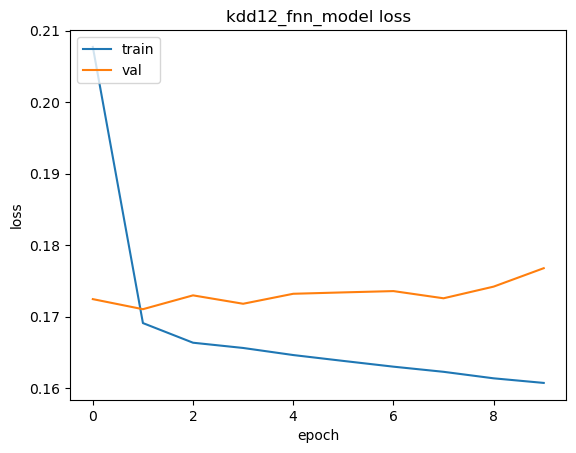

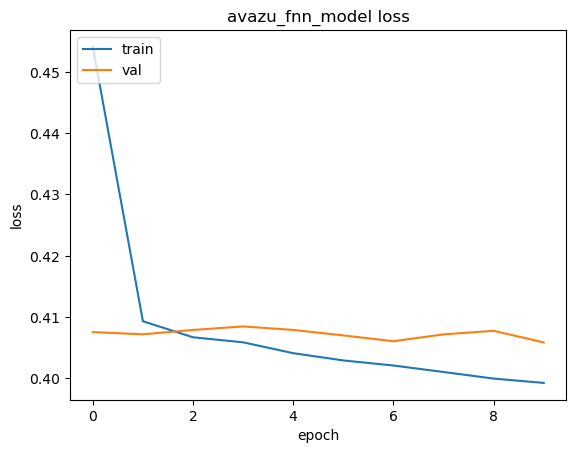

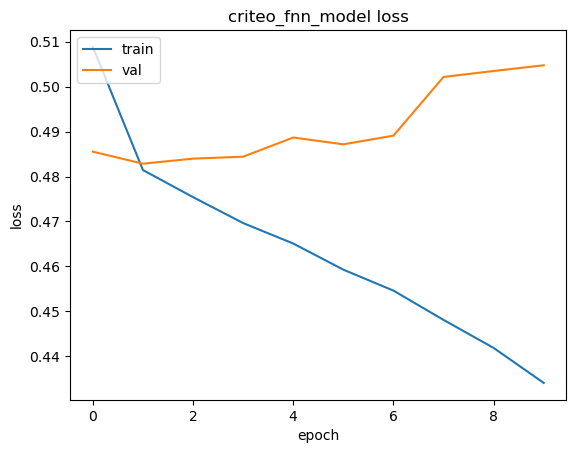

In [11]:
# Plot the training history
plt.plot(kdd12_fnn_history.history['binary_crossentropy'])
plt.plot(kdd12_fnn_history.history['val_binary_crossentropy'])
plt.title('kdd12_fnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_fnn_history.history['binary_crossentropy'])
plt.plot(avazu_fnn_history.history['val_binary_crossentropy'])
plt.title('avazu_fnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_fnn_history.history['binary_crossentropy'])
plt.plot(criteo_fnn_history.history['val_binary_crossentropy'])
plt.title('criteo_fnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
# Score the models
kdd12_fnn_score = kdd12_fnn_model.evaluate(kdd12_test_model_input, kdd12_val_y, batch_size=256)
avazu_fnn_score = avazu_fnn_model.evaluate(avazu_test_model_input, avazu_val_y, batch_size=256)
criteo_fnn_score = criteo_fnn_model.evaluate(criteo_test_model_input, criteo_val_y, batch_size=256)

79/79 [==============================] - 1s 10ms/step - loss: 0.5056 - binary_crossentropy: 0.5050


### Product Based Neural Networks

In [4]:
# Compile the PNN models
kdd12_pnn_model = PNN(kdd12_dnn_feature_columns, task='binary')
kdd12_pnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

avazu_pnn_model = PNN(avazu_dnn_feature_columns, task='binary')
avazu_pnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

criteo_pnn_model = PNN(criteo_dnn_feature_columns, task='binary')
criteo_pnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

2024-07-16 19:21:10.593124: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-07-16 19:21:10.594245: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-16 19:21:10.602000: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [5]:
# Fit the models
kdd12_pnn_history = kdd12_pnn_model.fit(kdd12_train_model_input, kdd12_train_y, batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
avazu_pnn_history = avazu_pnn_model.fit(avazu_train_model_input, avazu_train_y, batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
criteo_pnn_history = criteo_pnn_model.fit(criteo_train_model_input, criteo_train_y, batch_size=256, epochs=10, verbose=2, validation_split=0.2, )

2024-07-16 19:21:20.929241: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-07-16 19:21:20.939855: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Epoch 1/10
250/250 - 7s - loss: 0.2026 - binary_crossentropy: 0.2025 - val_loss: 0.1731 - val_binary_crossentropy: 0.1729
Epoch 2/10
250/250 - 4s - loss: 0.1690 - binary_crossentropy: 0.1687 - val_loss: 0.1715 - val_binary_crossentropy: 0.1711
Epoch 3/10
250/250 - 3s - loss: 0.1672 - binary_crossentropy: 0.1668 - val_loss: 0.1719 - val_binary_crossentropy: 0.1714
Epoch 4/10
250/250 - 3s - loss: 0.1660 - binary_crossentropy: 0.1655 - val_loss: 0.1724 - val_binary_crossentropy: 0.1719
Epoch 5/10
250/250 - 3s - loss: 0.1651 - binary_crossentropy: 0.1645 - val_loss: 0.1732 - val_binary_crossentropy: 0.1726
Epoch 6/10
250/250 - 3s - loss: 0.1644 - binary_crossentropy: 0.1638 - val_loss: 0.1738 - val_binary_crossentropy: 0.1732
Epoch 7/10
250/250 - 3s - loss: 0.1644 - binary_crossentropy: 0.1638 - val_loss: 0.1747 - val_binary_crossentropy: 0.1740
Epoch 8/10
250/250 - 3s - loss: 0.1634 - binary_crossentropy: 0.1627 - val_loss: 0.1747 - val_binary_crossentropy: 0.1740
Epoch 9/10
250/250 - 4s 

In [6]:
# Save the models
kdd12_pnn_model.save('models/pnn/kdd12_pnn_model.keras')
avazu_pnn_model.save('models/pnn/avazu_pnn_model.keras')
criteo_pnn_model.save('models/pnn/criteo_pnn_model.keras')

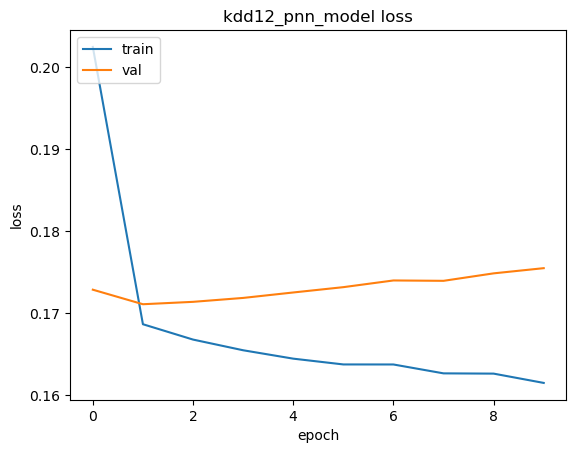

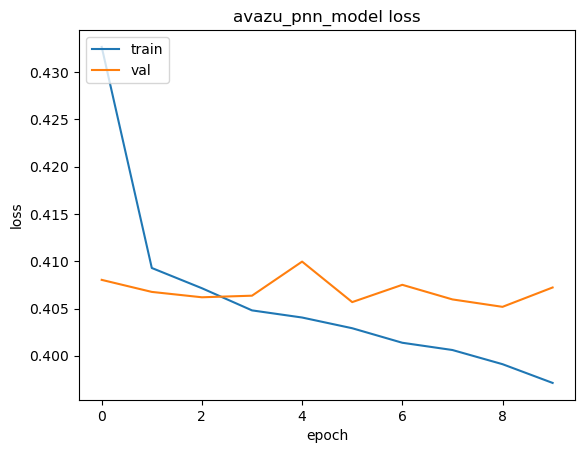

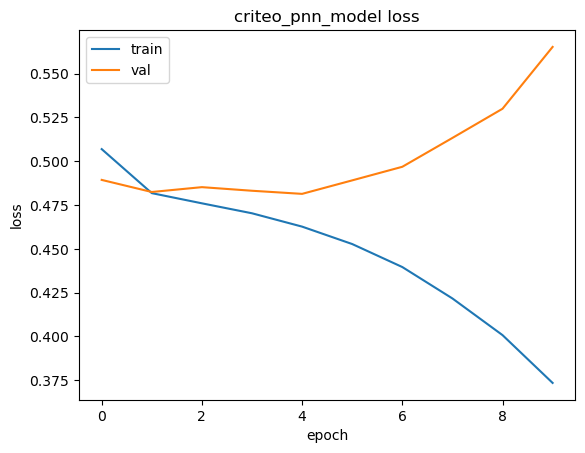

In [8]:
# Plot the training history
plt.plot(kdd12_pnn_history.history['binary_crossentropy'])
plt.plot(kdd12_pnn_history.history['val_binary_crossentropy'])
plt.title('kdd12_pnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_pnn_history.history['binary_crossentropy'])
plt.plot(avazu_pnn_history.history['val_binary_crossentropy'])
plt.title('avazu_pnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_pnn_history.history['binary_crossentropy'])
plt.plot(criteo_pnn_history.history['val_binary_crossentropy'])
plt.title('criteo_pnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Wide and Deep

In [3]:
# Compile the WDL models
kdd12_wdl_model = WDL(kdd12_linear_feature_columns, kdd12_dnn_feature_columns, task='binary')
kdd12_wdl_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

avazu_wdl_model = WDL(avazu_linear_feature_columns, avazu_dnn_feature_columns, task='binary')
avazu_wdl_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

criteo_wdl_model = WDL(criteo_linear_feature_columns, criteo_dnn_feature_columns, task='binary')
criteo_wdl_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

2024-07-16 19:58:52.079774: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-07-16 19:58:52.080443: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-16 19:58:52.083468: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [4]:
# Fit the Wide and Deep models
kdd12_wdl_history = kdd12_wdl_model.fit(kdd12_train_model_input, kdd12_train_y, batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
avazu_wdl_history = avazu_wdl_model.fit(avazu_train_model_input, avazu_train_y, batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
criteo_wdl_history = criteo_wdl_model.fit(criteo_train_model_input, criteo_train_y, batch_size=256, epochs=10, verbose=2, validation_split=0.2, )

2024-07-16 20:01:08.717088: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-07-16 20:01:08.717496: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Epoch 1/10
250/250 - 7s - loss: 0.2112 - binary_crossentropy: 0.2111 - val_loss: 0.1737 - val_binary_crossentropy: 0.1735
Epoch 2/10
250/250 - 4s - loss: 0.1692 - binary_crossentropy: 0.1689 - val_loss: 0.1715 - val_binary_crossentropy: 0.1711
Epoch 3/10
250/250 - 3s - loss: 0.1668 - binary_crossentropy: 0.1664 - val_loss: 0.1720 - val_binary_crossentropy: 0.1715
Epoch 4/10
250/250 - 4s - loss: 0.1656 - binary_crossentropy: 0.1650 - val_loss: 0.1740 - val_binary_crossentropy: 0.1734
Epoch 5/10
250/250 - 3s - loss: 0.1652 - binary_crossentropy: 0.1646 - val_loss: 0.1731 - val_binary_crossentropy: 0.1724
Epoch 6/10
250/250 - 3s - loss: 0.1643 - binary_crossentropy: 0.1636 - val_loss: 0.1749 - val_binary_crossentropy: 0.1743
Epoch 7/10
250/250 - 3s - loss: 0.1633 - binary_crossentropy: 0.1626 - val_loss: 0.1783 - val_binary_crossentropy: 0.1776
Epoch 8/10
250/250 - 3s - loss: 0.1625 - binary_crossentropy: 0.1618 - val_loss: 0.1750 - val_binary_crossentropy: 0.1743
Epoch 9/10
250/250 - 3s 

In [5]:
# Save the models
kdd12_wdl_model.save('models/wide_and_deep/kdd12_wdl_model.keras')
avazu_wdl_model.save('models/wide_and_deep/avazu_wdl_model.keras')
criteo_wdl_model.save('models/wide_and_deep/criteo_wdl_model.keras')

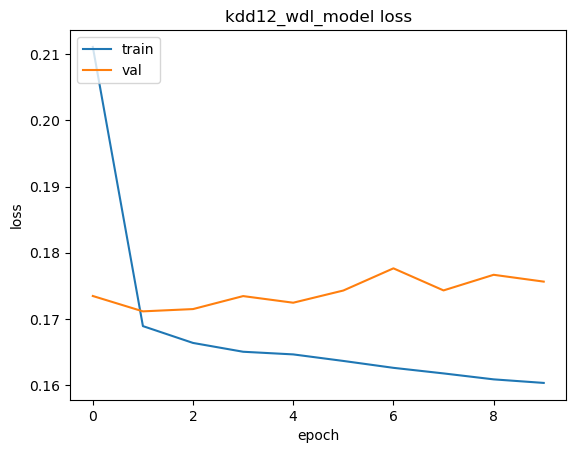

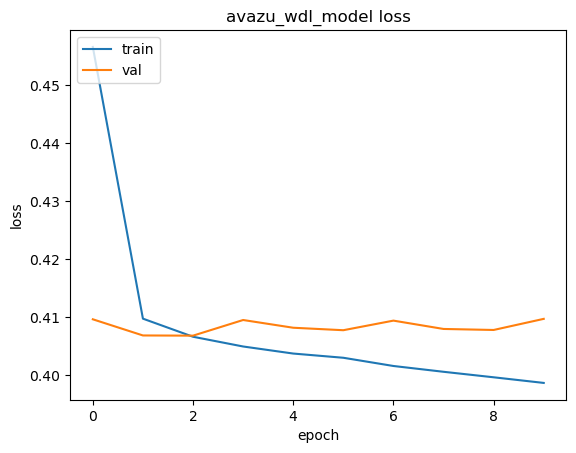

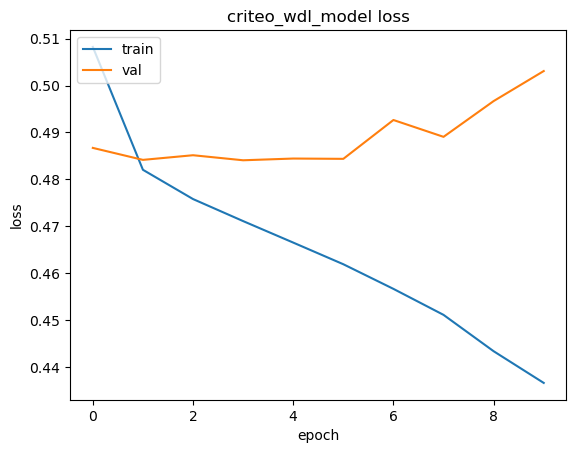

In [6]:
# Plot the training history
plt.plot(kdd12_wdl_history.history['binary_crossentropy'])
plt.plot(kdd12_wdl_history.history['val_binary_crossentropy'])
plt.title('kdd12_wdl_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_wdl_history.history['binary_crossentropy'])
plt.plot(avazu_wdl_history.history['val_binary_crossentropy'])
plt.title('avazu_wdl_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_wdl_history.history['binary_crossentropy'])
plt.plot(criteo_wdl_history.history['val_binary_crossentropy'])
plt.title('criteo_wdl_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### DeepFM

In [9]:
# Add this to the preamble
from deepctr.models.deepfm import DeepFM
from tensorflow.keras.callbacks import CSVLogger

In [4]:
# Compile the DeepFM models
kdd12_dfm_model = DeepFM(kdd12_linear_feature_columns, kdd12_dnn_feature_columns, task='binary')
kdd12_dfm_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

avazu_dfm_model = DeepFM(avazu_linear_feature_columns, avazu_dnn_feature_columns, task='binary')
avazu_dfm_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

criteo_dfm_model = DeepFM(criteo_linear_feature_columns, criteo_dnn_feature_columns, task='binary')
criteo_dfm_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

2024-07-23 17:38:36.663933: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-07-23 17:38:36.665190: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-23 17:38:36.675451: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [6]:
# Define the CSVLogger callbacks
kdd12_dfm_csvLogger = CSVLogger('logs/kdd12_dfm.csv')
avazu_dfm_csvLogger = CSVLogger('logs/avazu_dfm.csv')
criteo_dfm_csvLogger = CSVLogger('logs/criteo_dfm.csv')

In [7]:
# Fit the DeepFM models
kdd12_dfm_history = kdd12_dfm_model.fit(kdd12_train_model_input, kdd12_train_y, batch_size=256, epochs=10, verbose=2, validation_split=0.2, callbacks=[kdd12_dfm_csvLogger])
avazu_dfm_history = avazu_dfm_model.fit(avazu_train_model_input, avazu_train_y, batch_size=256, epochs=10, verbose=2, validation_split=0.2, callbacks=[avazu_dfm_csvLogger])
criteo_dfm_history = criteo_dfm_model.fit(criteo_train_model_input, criteo_train_y, batch_size=256, epochs=10, verbose=2, validation_split=0.2, callbacks=[criteo_dfm_csvLogger])

2024-07-23 17:49:05.132558: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-07-23 17:49:05.142715: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Epoch 1/10
250/250 - 9s - loss: 0.2054 - binary_crossentropy: 0.2053 - val_loss: 0.1731 - val_binary_crossentropy: 0.1729
Epoch 2/10
250/250 - 4s - loss: 0.1696 - binary_crossentropy: 0.1693 - val_loss: 0.1712 - val_binary_crossentropy: 0.1709
Epoch 3/10
250/250 - 3s - loss: 0.1667 - binary_crossentropy: 0.1663 - val_loss: 0.1727 - val_binary_crossentropy: 0.1722
Epoch 4/10
250/250 - 4s - loss: 0.1660 - binary_crossentropy: 0.1655 - val_loss: 0.1741 - val_binary_crossentropy: 0.1735
Epoch 5/10
250/250 - 3s - loss: 0.1646 - binary_crossentropy: 0.1640 - val_loss: 0.1744 - val_binary_crossentropy: 0.1738
Epoch 6/10
250/250 - 3s - loss: 0.1637 - binary_crossentropy: 0.1630 - val_loss: 0.1739 - val_binary_crossentropy: 0.1733
Epoch 7/10
250/250 - 3s - loss: 0.1629 - binary_crossentropy: 0.1622 - val_loss: 0.1748 - val_binary_crossentropy: 0.1741
Epoch 8/10
250/250 - 4s - loss: 0.1622 - binary_crossentropy: 0.1615 - val_loss: 0.1747 - val_binary_crossentropy: 0.1740
Epoch 9/10
250/250 - 4s 

In [8]:
# Save the models
kdd12_dfm_model.save('models/deepfm/kdd12_dfm_model.keras')
avazu_dfm_model.save('models/deepfm/avazu_dfm_model.keras')
criteo_dfm_model.save('models/deepfm/criteo_dfm_model.keras')

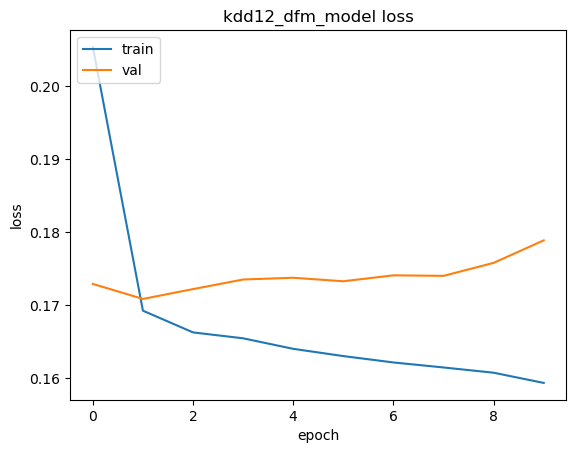

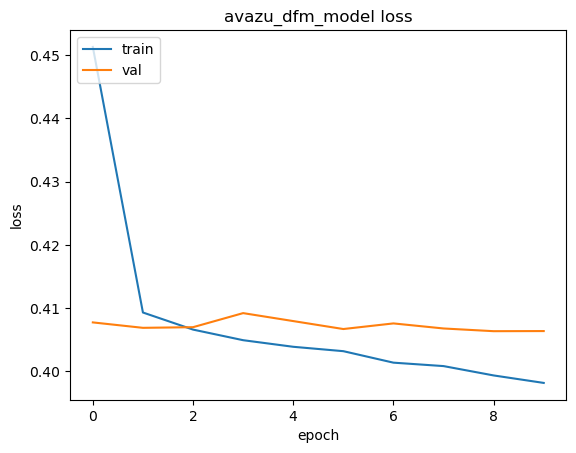

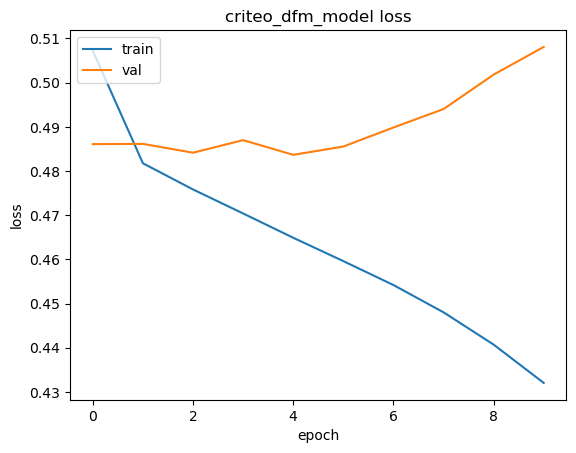

In [10]:
# Read in the history logs
kdd12_dfm_history = pd.read_csv('logs/kdd12_dfm.csv')
avazu_dfm_history = pd.read_csv('logs/avazu_dfm.csv')
criteo_dfm_history = pd.read_csv('logs/criteo_dfm.csv')

# Plot the training history
plt.plot(kdd12_dfm_history['binary_crossentropy'])
plt.plot(kdd12_dfm_history['val_binary_crossentropy'])
plt.title('kdd12_dfm_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_dfm_history['binary_crossentropy'])
plt.plot(avazu_dfm_history['val_binary_crossentropy'])
plt.title('avazu_dfm_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_dfm_history['binary_crossentropy'])
plt.plot(criteo_dfm_history['val_binary_crossentropy'])
plt.title('criteo_dfm_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Feature Generation by convolutional Neural Network - FGCNN

In [4]:
# Add the following to the preamble
from deepctr.models.fgcnn import FGCNN

In [5]:
# Compile the FGCNN models

kdd12_fgcnn_model = FGCNN(kdd12_linear_feature_columns, kdd12_dnn_feature_columns, task='binary')
kdd12_fgcnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

avazu_fgcnn_model = FGCNN(avazu_linear_feature_columns, avazu_dnn_feature_columns, task='binary')
avazu_fgcnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

criteo_fgcnn_model = FGCNN(criteo_linear_feature_columns, criteo_dnn_feature_columns, task='binary')
criteo_fgcnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

2024-07-23 18:12:20.338481: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-07-23 18:12:20.338725: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-23 18:12:20.342145: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ValueError: Negative dimension size caused by subtracting 2 from 1 for '{{node fgcnn_layer/max_pooling2d_3/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 1, 1], padding="VALID", strides=[1, 2, 1, 1]](fgcnn_layer/conv2d_3/Tanh)' with input shapes: [?,1,4,20].

### Automatic Feature Interaction (AutoInt)

In [6]:
# Add this to the preamble
from deepctr.models.autoint import AutoInt

In [7]:
# Compile the AutoInt Models
kdd12_autoint_model = AutoInt(kdd12_linear_feature_columns, kdd12_dnn_feature_columns, task='binary')
kdd12_autoint_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

avazu_autoint_model = AutoInt(avazu_linear_feature_columns, avazu_dnn_feature_columns, task='binary')
avazu_autoint_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

criteo_autoint_model = AutoInt(criteo_linear_feature_columns, criteo_dnn_feature_columns, task='binary')
criteo_autoint_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [10]:
# Define the AutoInt CSVLogger callbacks
kdd12_autoint_csvLogger = CSVLogger('logs/kdd12_autoint.csv')
avazu_autoint_csvLogger = CSVLogger('logs/avazu_autoint.csv')
criteo_autoint_csvLogger = CSVLogger('logs/criteo_autoint.csv')

In [11]:
# Fit the AutoInt models
kdd12_autoint_model.fit(kdd12_train_model_input, kdd12_train_y, batch_size=256, epochs=10, verbose=2, validation_split=0.2, callbacks=[kdd12_autoint_csvLogger])
avazu_autoint_model.fit(avazu_train_model_input, avazu_train_y, batch_size=256, epochs=10, verbose=2, validation_split=0.2, callbacks=[avazu_autoint_csvLogger])
criteo_autoint_model.fit(criteo_train_model_input, criteo_train_y, batch_size=256, epochs=10, verbose=2, validation_split=0.2, callbacks=[criteo_autoint_csvLogger])

2024-07-23 18:25:53.622273: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-07-23 18:25:53.622615: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Epoch 1/10
250/250 - 13s - loss: 0.2118 - binary_crossentropy: 0.2117 - val_loss: 0.1741 - val_binary_crossentropy: 0.1740
Epoch 2/10
250/250 - 7s - loss: 0.1702 - binary_crossentropy: 0.1701 - val_loss: 0.1717 - val_binary_crossentropy: 0.1715
Epoch 3/10
250/250 - 7s - loss: 0.1666 - binary_crossentropy: 0.1665 - val_loss: 0.1723 - val_binary_crossentropy: 0.1721
Epoch 4/10
250/250 - 7s - loss: 0.1654 - binary_crossentropy: 0.1652 - val_loss: 0.1736 - val_binary_crossentropy: 0.1733
Epoch 5/10
250/250 - 6s - loss: 0.1643 - binary_crossentropy: 0.1641 - val_loss: 0.1738 - val_binary_crossentropy: 0.1736
Epoch 6/10
250/250 - 7s - loss: 0.1636 - binary_crossentropy: 0.1633 - val_loss: 0.1738 - val_binary_crossentropy: 0.1735
Epoch 7/10
250/250 - 7s - loss: 0.1631 - binary_crossentropy: 0.1628 - val_loss: 0.1759 - val_binary_crossentropy: 0.1756
Epoch 8/10
250/250 - 7s - loss: 0.1624 - binary_crossentropy: 0.1620 - val_loss: 0.1775 - val_binary_crossentropy: 0.1771
Epoch 9/10
250/250 - 7s

In [13]:
# Save the models
kdd12_autoint_model.save('models/autoint/kdd12_autoint_model.keras')
avazu_autoint_model.save('models/autoint/avazu_autoint_model.keras')
criteo_autoint_model.save('models/autoint/criteo_autoint_model.keras')

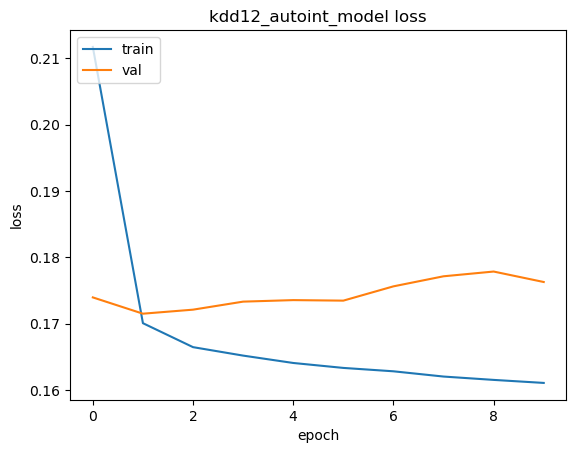

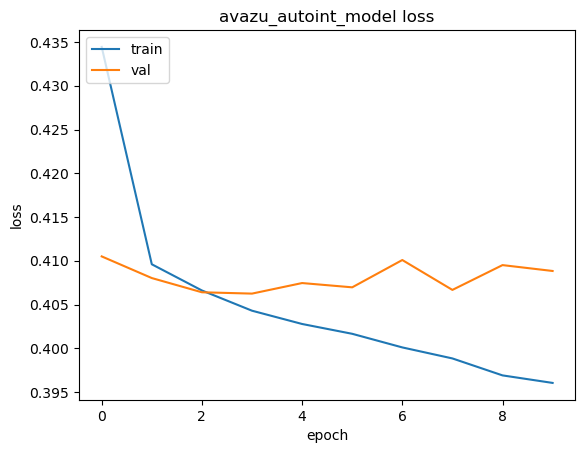

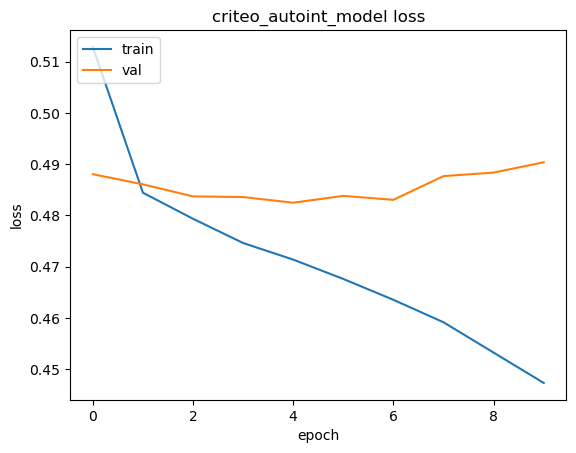

In [12]:
# Read in the history logs
kdd12_autoint_history = pd.read_csv('logs/kdd12_autoint.csv')
avazu_autoint_history = pd.read_csv('logs/avazu_autoint.csv')
criteo_autoint_history = pd.read_csv('logs/criteo_autoint.csv')

# Plot the training history
plt.plot(kdd12_autoint_history['binary_crossentropy'])
plt.plot(kdd12_autoint_history['val_binary_crossentropy'])
plt.title('kdd12_autoint_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_autoint_history['binary_crossentropy'])
plt.plot(avazu_autoint_history['val_binary_crossentropy'])
plt.title('avazu_autoint_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_autoint_history['binary_crossentropy'])
plt.plot(criteo_autoint_history['val_binary_crossentropy'])
plt.title('criteo_autoint_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()